# Sentiment Analysis with MLP and Model Optimization Techniques

This notebook demonstrates the process of training a Multi-Layer Perceptron (MLP) for sentiment analysis on the SST-2 dataset. It covers:

1.  **Data Loading and Preprocessing**: Using Pandas and Scikit-learn's TF-IDF vectorizer.
2.  **Model Definition**: Creating an MLP using PyTorch.
3.  **Training**: Training the MLP with a validation split.
4.  **Evaluation**: Assessing the baseline model performance.
5.  **Model Optimization**: Applying Dynamic Quantization and Half-Precision (FP16) techniques.
6.  **Comparison**: Comparing the accuracy, model size, and inference speed of the original and optimized models.

The goal is to show how model optimization techniques can reduce model size and potentially speed up inference, often with minimal impact on accuracy.

## 1. Setup and Imports

First, we install the `prettytable` library for displaying results in a formatted table. Then, we import all necessary libraries: `pandas` for data manipulation, `torch` for building and training the neural network, `sklearn` for TF-IDF vectorization and data splitting, `matplotlib` for plotting, and standard Python libraries like `os` and `time`.

In [ ]:
!pip install prettytable -q

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.quantization as quant
import time
import os
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable

## 2. Data Loading

We download the Stanford Sentiment Treebank (SST-2) dataset, which contains movie reviews labeled with sentiment (positive/negative). The dataset is provided as tab-separated value (TSV) files.

We load the training and test sets using `pandas`. Since the files don't have a header row, we specify `header=None`. We then assign meaningful column names: 'sentence' for the review text and 'label' for the sentiment (0 for negative, 1 for positive).

In [ ]:
# URLs for the datasets
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

# Load DataFrames without header and rename columns
train_df = pd.read_csv(train_url, delimiter='\t', header=None)
train_df.columns = ['sentence', 'label']
test_df = pd.read_csv(test_url, delimiter='\t', header=None)
test_df.columns = ['sentence', 'label']
# Display the first few rows of the training data
print("Training Data Head:")
print(train_df.head())

# Display the first few rows of the test data
print("\nTest Data Head:")
print(test_df.head())

Training Data Head:
                                            sentence  label
0  a stirring , funny and finally transporting re...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo n't sit still f...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker 's bartleby should have been t...      1

Test Data Head:
                                            sentence  label
0       no movement , no yuks , not much of anything      0
1  a gob of drivel so sickly sweet , even the eag...      0
2  gangs of new york is an unapologetic mess , wh...      0
3  we never really feel involved with the story ,...      0
4              this is one of polanski 's best films      1


## 3. Data Preprocessing (TF-IDF Vectorization)

Neural networks require numerical input. We convert the raw text sentences into numerical feature vectors using Term Frequency-Inverse Document Frequency (TF-IDF).

*   **TF-IDF**: This technique reflects how important a word is to a document in a collection or corpus. It increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.
*   **Vectorizer**: We initialize `TfidfVectorizer` from `scikit-learn`. `max_features=10000` limits the vocabulary size to the 10,000 most frequent terms across the training corpus.
*   **Fit and Transform**: We `fit` the vectorizer on the *training data* only (`fit_transform`) to learn the vocabulary and IDF weights. Then, we `transform` both the training and test data using the *fitted* vectorizer. This ensures consistency and prevents data leakage from the test set into the vocabulary.
*   **Output**: The result is a sparse matrix, which we convert to a dense NumPy array (`.toarray()`) for compatibility with PyTorch tensors.
*   **Labels**: We extract the numerical labels (0 or 1) from the dataframes.

In [ ]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)  # Limit to 10000 features

# Fit the vectorizer on the training data and transform it
print("Fitting TF-IDF on training data and transforming...")
train_features = vectorizer.fit_transform(train_df['sentence']).toarray()

# Transform the test data using the fitted vectorizer
print("Transforming test data...")
test_features = vectorizer.transform(test_df['sentence']).toarray()

# Get labels as NumPy arrays
train_labels = train_df['label'].values
test_labels = test_df['label'].values

print(f"\nShape of training features: {train_features.shape}")
print(f"Shape of test features: {test_features.shape}")
print(f"Shape of training labels: {train_labels.shape}")
print(f"Shape of test labels: {test_labels.shape}")

Fitting TF-IDF on training data and transforming...
Transforming test data...

Shape of training features: (6920, 10000)
Shape of test features: (1821, 10000)
Shape of training labels: (6920,)
Shape of test labels: (1821,)


## 4. PyTorch Data Preparation

We convert the NumPy arrays (features and labels) into PyTorch tensors.

*   **Tensors**: Features are converted to `torch.float32`, and labels are converted to `torch.long` (required by `CrossEntropyLoss`).
*   **TensorDataset**: This PyTorch utility wraps the feature and label tensors together, allowing easy access to corresponding pairs.
*   **DataLoader**: This utility provides an iterator for efficiently loading data in batches during training and evaluation. It handles shuffling (`shuffle=True` for training) and batching (`batch_size=32`). We create initial DataLoaders here; the training loader will be modified later for the validation split.

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32),
                              torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32),
                             torch.tensor(test_labels, dtype=torch.long))

# Create initial DataLoaders (train_loader will be redefined after split)
train_loader_full = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 6920
Number of test samples: 1821


## 5. Model Definition (MLP)

We define a Multi-Layer Perceptron (MLP) model using PyTorch's `nn.Module`.

*   **Architecture**: The MLP consists of several fully connected (`nn.Linear`) layers with ReLU activation functions (`nn.ReLU`) and Dropout (`nn.Dropout`) for regularization.
    *   Input layer: Takes the TF-IDF feature dimension (10000) as input.
    *   Hidden layers: Reduce dimensionality progressively (512 -> 256 -> 128 -> 64).
    *   Output layer: Produces 2 outputs, corresponding to the scores for the two sentiment classes (negative, positive).
*   **Dropout**: Applied after each ReLU activation in the hidden layers to prevent overfitting by randomly setting a fraction (`dropout_prob=0.3`) of neuron activations to zero during training.
*   **`__init__`**: Initializes the layers sequence.
*   **`forward`**: Defines the forward pass of data through the layers.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=10000, hidden_sizes=[512, 256, 128, 64], output_dim=2, dropout_prob=0.3):
        super(MLP, self).__init__()
        # Define the sequence of layers
        self.layers = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            # Layer 2
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            # Layer 3
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            # Layer 4
            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            # Output Layer
            nn.Linear(hidden_sizes[3], output_dim)
        )

    def forward(self, x):
        # Pass input through the sequential layers
        return self.layers(x)

## 6. Model Instantiation and Setup

*   **Instantiation**: We create an instance of our `MLP` model.
*   **Parameter Count**: We define a helper function `count_parameters` to calculate and display the total number of trainable parameters in the model.
*   **Device**: We check if a CUDA-enabled GPU is available (`torch.cuda.is_available()`). If yes, we set the `device` to 'cuda'; otherwise, we use the 'cpu'. Google Colab often provides free GPU access (check Runtime -> Change runtime type).
*   **Move Model**: We move the instantiated model to the selected `device` using `.to(device)`. This ensures computations involving the model's parameters happen on the GPU if available.

In [ ]:
# Instantiate the model
mlp = MLP()

# Helper function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(mlp):,}")

# Define device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
mlp = mlp.to(device)

Total trainable parameters: 5,293,122
Using device: cuda


## 7. Training Setup

We set up the components needed for the training loop:

*   **Loss Function**: `nn.CrossEntropyLoss` is suitable for classification tasks. It combines `LogSoftmax` and `NLLLoss` in one class and expects raw scores (logits) from the model and class indices as targets.
*   **Optimizer**: `optim.Adam` is an adaptive learning rate optimization algorithm that's widely used and generally performs well.
*   **Epochs**: `num_epochs = 10` defines how many times we iterate over the entire training dataset.
*   **Tracking**: We initialize variables to track the best validation accuracy (`best_val_acc`) for checkpointing and lists to store training loss, validation loss, and validation accuracy for plotting.
*   **Train/Validation Split**: We split the original *training dataset* into a new training set (80%) and a validation set (20%) using `train_test_split` on the indices. This validation set is crucial for monitoring model performance on unseen data during training and preventing overfitting.
*   **Samplers**: `SubsetRandomSampler` is used to create DataLoaders that only sample from the specified training or validation indices.
*   **New DataLoaders**: We create new `train_loader` and `val_loader` using the original `train_dataset` but with the respective samplers to ensure they draw data only from the correct split.

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

# Number of training epochs
num_epochs = 10

# Variables for tracking best model and metrics
best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []

# Split the training data indices into training and validation sets (80% train, 20% val)
train_indices, val_indices = train_test_split(
    range(len(train_dataset)), test_size=0.2, random_state=42 # Use a fixed random state for reproducibility
)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoaders for training and validation using the samplers
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)

print(f"Size of new training set: {len(train_indices)}")
print(f"Size of validation set: {len(val_indices)}")

Size of new training set: 5536
Size of validation set: 1384


## 8. Training Loop

This is the main loop where the model learns from the data.

For each epoch:
1.  **Set to Training Mode**: `mlp.train()` puts the model in training mode. This enables dropout and batch normalization updates (if used).
2.  **Iterate through Training Data**: Loop through batches provided by `train_loader`.
3.  **Move Data to Device**: Transfer the input data (`data`) and target labels (`target`) to the selected `device` (GPU/CPU).
4.  **Zero Gradients**: `optimizer.zero_grad()` clears gradients from the previous iteration.
5.  **Forward Pass**: `outputs = mlp(data)` computes the model's predictions for the batch.
6.  **Calculate Loss**: `loss = criterion(outputs, target)` calculates the difference between predictions and actual labels.
7.  **Backward Pass**: `loss.backward()` computes gradients of the loss with respect to model parameters.
8.  **Optimizer Step**: `optimizer.step()` updates the model parameters based on the computed gradients.
9.  **Track Training Loss**: Accumulate the loss for the epoch.

After processing all training batches:
10. **Set to Evaluation Mode**: `mlp.eval()` puts the model in evaluation mode. This disables dropout and fixes batch normalization statistics.
11. **Validation Phase**: Loop through batches from `val_loader`.
    *   **Disable Gradient Calculation**: `with torch.no_grad():` significantly speeds up computation and reduces memory usage during evaluation, as gradients are not needed.
    *   **Calculate Validation Loss and Accuracy**: Compute loss and accuracy on the validation set.
12. **Record Metrics**: Store the average training loss, validation loss, and validation accuracy for the epoch.
13. **Print Progress**: Display the metrics for the current epoch.
14. **Checkpointing**: If the current validation accuracy (`val_acc`) is better than the `best_val_acc` seen so far, save the model's state dictionary (`mlp.state_dict()`) to a file (`checkpoint.pt`). This saves the best performing model based on validation performance.

In [ ]:
print("Starting Training...")
start_train_time = time.time()

for epoch in range(num_epochs):
    # --- Training Phase ---
    mlp.train()  # Set model to training mode
    running_train_loss = 0.0

    for data, target in train_loader:
        # Move data and target tensors to the configured device
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = mlp(data)

        # Calculate the batch loss
        loss = criterion(outputs, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        running_train_loss += loss.item() * data.size(0)

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_indices)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    mlp.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculations
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = mlp(data)
            loss = criterion(outputs, target)
            running_val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_indices)
    epoch_val_acc = 100.0 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {epoch_val_acc:.2f}%" ) # Removed incorrect variable reference

    # Save checkpoint if validation accuracy improves
    if epoch_val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% --> {epoch_val_acc:.2f}%). Saving model...")
        best_val_acc = epoch_val_acc
        torch.save(mlp.state_dict(), "checkpoint.pt")

end_train_time = time.time()
print(f"\nTraining finished in {end_train_time - start_train_time:.2f} seconds.")
print(f"Best validation accuracy: {best_val_acc:.2f}%" )

Starting Training...
Epoch 1/10 - Train Loss: 0.5889, Val Loss: 0.4488, Val Accuracy: 78.90%
Validation accuracy improved (0.00% --> 78.90%). Saving model...
Epoch 2/10 - Train Loss: 0.2556, Val Loss: 0.4442, Val Accuracy: 80.92%
Validation accuracy improved (78.90% --> 80.92%). Saving model...
Epoch 3/10 - Train Loss: 0.0765, Val Loss: 0.6054, Val Accuracy: 80.13%
Epoch 4/10 - Train Loss: 0.0268, Val Loss: 0.9850, Val Accuracy: 78.76%
Epoch 5/10 - Train Loss: 0.0094, Val Loss: 1.2358, Val Accuracy: 78.90%
Epoch 6/10 - Train Loss: 0.0028, Val Loss: 1.5898, Val Accuracy: 79.05%
Epoch 7/10 - Train Loss: 0.0013, Val Loss: 1.8945, Val Accuracy: 79.05%
Epoch 8/10 - Train Loss: 0.0041, Val Loss: 1.7283, Val Accuracy: 79.55%
Epoch 9/10 - Train Loss: 0.0003, Val Loss: 2.1460, Val Accuracy: 79.55%
Epoch 10/10 - Train Loss: 0.0021, Val Loss: 1.9785, Val Accuracy: 78.97%

Training finished in 11.64 seconds.
Best validation accuracy: 80.92%


## 9. Plotting Training Results

We visualize the validation loss and validation accuracy over the training epochs. This helps understand the model's learning progress and identify potential issues like overfitting (where validation loss starts increasing while training loss continues decreasing).

*   We use `matplotlib` to create two subplots:
    *   Epoch vs. Validation Loss
    *   Epoch vs. Validation Accuracy
*   Clear labels and titles make the plots easy to interpret.

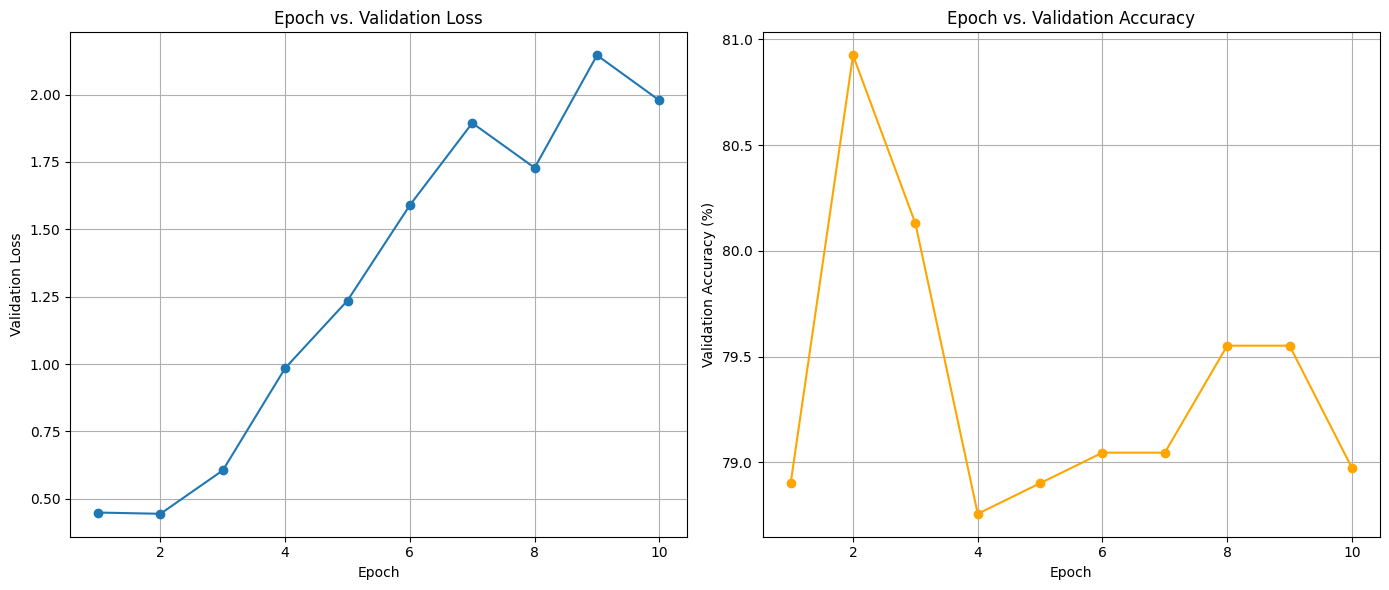

In [ ]:
# Plot the validation loss and accuracy curves
plt.figure(figsize=(14, 6))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Epoch vs. Validation Loss")
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', linestyle='-', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Epoch vs. Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

## 10. Helper Functions for Evaluation

We define two helper functions to streamline the evaluation process for different model versions (original, quantized, etc.).

1.  **`evaluate_model(model, loader, device, use_half=False)`**:
    *   Takes a model, data loader, device, and a flag `use_half` as input.
    *   Sets the model to evaluation mode (`model.eval()`).
    *   Iterates through the data loader *without* calculating gradients (`torch.no_grad()`).
    *   Measures the time taken for inference across the entire dataset.
    *   Calculates the overall accuracy.
    *   If `use_half` is True, it converts input data to `half()` precision before feeding it to the model (required for FP16 evaluation).
    *   Returns the accuracy (in %) and total inference time (in milliseconds).

2.  **`get_model_file_size(model, filename="temp_model.pt")`**:
    *   Takes a model and a temporary filename as input.
    *   Saves the model's state dictionary to the specified file.
    *   Gets the size of the saved file using `os.path.getsize()`.
    *   Removes the temporary file.
    *   Returns the file size in Megabytes (MB).

In [ ]:
def evaluate_model(model, loader, device, use_half=False):
    """Evaluates accuracy over the dataset and measures inference time."""
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            # Convert input data to half precision if required
            if use_half:
                data = data.half()
            # Get model predictions
            outputs = model(data)
            # Get the index of the max log-probability (predicted class)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    accuracy = 100.0 * correct / total
    print(f"Evaluation completed in {inference_time:.2f} ms. Accuracy: {accuracy:.2f}%")
    return accuracy, inference_time

def get_model_file_size(model, filename="temp_model.pt"):
    """Saves the model state temporarily and returns file size in MB."""
    # Ensure model is on CPU before saving for consistent size measurement if needed,
    # but state_dict size is generally independent of device it was trained on.
    torch.save(model.state_dict(), filename)
    # Get file size in bytes and convert to Megabytes
    size_bytes = os.path.getsize(filename)
    size_mb = size_bytes / (1024 * 1024)
    # Remove the temporary file
    os.remove(filename)
    print(f"Calculated model size: {size_mb:.2f} MB")
    return size_mb

## 11. Evaluate Original Model (FP32)

Now, we evaluate the performance of the original, trained model (using 32-bit floating-point precision, FP32) on the **test set**.

1.  **Load Best Checkpoint**: We load the weights from the `checkpoint.pt` file saved during training (which corresponds to the epoch with the highest validation accuracy) into our `mlp` model instance.
2.  **Ensure Model on Device**: We make sure the model is on the correct `device` (especially important if the runtime was restarted).
3.  **Evaluate**: We call `evaluate_model` using the test loader (`test_loader`).
4.  **Get Size**: We call `get_model_file_size` to measure the storage footprint.
5.  **Store Results**: We store the accuracy, inference time, and size for later comparison.

In [ ]:
# Load the best performing checkpoint
print("Loading best model checkpoint...")
mlp.load_state_dict(torch.load("checkpoint.pt", map_location=device))
mlp.to(device) # Ensure model is on the correct device

# Evaluate the original model
print("\nEvaluating Original FP32 Model on Test Set:")
orig_acc, orig_infer_time = evaluate_model(mlp, test_loader, device)
orig_size = get_model_file_size(mlp, "orig_model.pt")

print("--- Original Model Summary ---")
print(f"Accuracy: {orig_acc:.2f}% | Inference Time: {orig_infer_time:.2f} ms | Storage: {orig_size:.2f} MB")

Loading best model checkpoint...

Evaluating Original FP32 Model on Test Set:
Evaluation completed in 104.26 ms. Accuracy: 81.11%
Calculated model size: 20.20 MB
--- Original Model Summary ---
Accuracy: 81.11% | Inference Time: 104.26 ms | Storage: 20.20 MB


## 12. Apply and Evaluate Dynamic Quantization (INT8)

**Dynamic Quantization**: This technique converts model weights to a lower precision format (like 8-bit integer, INT8) ahead of time, but determines the scaling factors for activations *dynamically* during inference. It's relatively easy to apply (post-training) and primarily benefits CPU inference speed and model size, especially for linear layers and LSTMs.

1.  **Apply Quantization**: We use `torch.quantization.quantize_dynamic`.
    *   The first argument is the trained model (`mlp`).
    *   The second argument (`{nn.Linear}`) specifies the types of layers to quantize. Here, we target only the `Linear` layers.
    *   `dtype=torch.qint8` specifies the target data type (8-bit signed integer).
2.  **Move to Device**: The quantized model is moved to the target device. Note: Dynamic quantization is often most effective on CPU.
3.  **Evaluate**: We evaluate the `dynamic_model` using the `evaluate_model` function.
4.  **Get Size**: We measure the size of the quantized model.
5.  **Store Results**: We store the metrics for comparison.

In [ ]:
# Apply Dynamic Quantization
print("\nApplying Dynamic Quantization...")
# Ensure the original model (best checkpoint) is loaded and on the CPU for quantization
# Note: Dynamic Quantization typically targets CPU execution
mlp_cpu = MLP()
mlp_cpu.load_state_dict(torch.load("checkpoint.pt", map_location="cpu"))
mlp_cpu.eval() # Set to evaluation mode before quantization

dynamic_model = quant.quantize_dynamic(
    mlp_cpu, {nn.Linear}, dtype=torch.qint8
)

# Dynamic quantization primarily benefits CPU, so evaluate on CPU
quant_device = torch.device("cpu")
dynamic_model.to(quant_device)
print(f"Quantized model placed on: {quant_device}")

# Evaluate the dynamic quantized model
print("\nEvaluating Dynamic Quantization (INT8) Model on Test Set:")
dyn_acc, dyn_infer_time = evaluate_model(dynamic_model, test_loader, quant_device)
dyn_size = get_model_file_size(dynamic_model, "dynamic_model.pt")

print("--- Dynamic Quantization Model Summary ---")
print(f"Accuracy: {dyn_acc:.2f}% | Inference Time: {dyn_infer_time:.2f} ms | Storage: {dyn_size:.2f} MB")


Applying Dynamic Quantization...
Quantized model placed on: cpu

Evaluating Dynamic Quantization (INT8) Model on Test Set:
Evaluation completed in 321.27 ms. Accuracy: 80.89%
Calculated model size: 5.06 MB
--- Dynamic Quantization Model Summary ---
Accuracy: 80.89% | Inference Time: 321.27 ms | Storage: 5.06 MB


## 13. Apply and Evaluate Half Precision (FP16)

**Half Precision (FP16)**: This involves using 16-bit floating-point numbers instead of the standard 32-bit (FP32). It can significantly reduce model size (by roughly half) and speed up computation, especially on GPUs with specialized Tensor Cores (like V100, T4, A100 available in Colab Pro).

1.  **Reload Best Model**: We reload the best FP32 checkpoint into the original `mlp` model structure to ensure we start from the trained weights.
2.  **Convert to Half**: We convert the model's parameters and buffers to FP16 using `.half()`.
3.  **Move to Device**: The FP16 model is moved to the target `device`. For FP16, this should ideally be a CUDA GPU for performance benefits.
4.  **Evaluate**: We evaluate the `half_model` using `evaluate_model`, crucially passing `use_half=True`. This tells the evaluation function to also convert the *input data* to `.half()` before feeding it to the model, as FP16 models expect FP16 inputs.
5.  **Get Size**: We measure the size of the half-precision model.
6.  **Store Results**: We store the metrics for comparison.

In [ ]:
# Reload the original model weights before converting to half precision
print("\nReloading best model checkpoint for FP16 conversion...")
mlp.load_state_dict(torch.load("checkpoint.pt", map_location=device))
mlp.to(device) # Ensure model is on the correct device
mlp.eval() # Set to eval mode

# Convert model to half precision
print("Converting model to Half Precision (FP16)...")
half_model = mlp.half()
# Ensure the half model is on the GPU if available, as FP16 benefits are mainly on GPU
half_model.to(device)
print(f"Half precision model placed on: {device}")

# Evaluate the half precision model
# Note: Requires input data to be converted to half() as well.
print("\nEvaluating Half Precision (FP16) Model on Test Set:")
half_acc, half_infer_time = evaluate_model(half_model, test_loader, device, use_half=True)
half_size = get_model_file_size(half_model, "half_model.pt")

print("--- Half Precision Model Summary ---")
print(f"Accuracy: {half_acc:.2f}% | Inference Time: {half_infer_time:.2f} ms | Storage: {half_size:.2f} MB")


Reloading best model checkpoint for FP16 conversion...
Converting model to Half Precision (FP16)...
Half precision model placed on: cuda

Evaluating Half Precision (FP16) Model on Test Set:
Evaluation completed in 239.80 ms. Accuracy: 81.11%
Calculated model size: 10.10 MB
--- Half Precision Model Summary ---
Accuracy: 81.11% | Inference Time: 239.80 ms | Storage: 10.10 MB


## 14. Comparison Summary

Finally, we compile the results (accuracy, storage size, inference time) for the original FP32 model, the dynamically quantized INT8 model, and the half-precision FP16 model into a summary table using `PrettyTable`. This provides a clear comparison of the trade-offs involved with each optimization technique.

**Expected Observations (Typical):**
*   **Size**: Dynamic Quantization and Half Precision should significantly reduce model size compared to the original FP32 model.
*   **Inference Time**:
    *   Dynamic Quantization often speeds up inference, especially on CPU.
    *   Half Precision can speed up inference significantly, especially on compatible GPUs.
*   **Accuracy**: Both techniques might cause a small drop in accuracy, but often the difference is minimal and acceptable given the benefits in size and speed.

In [ ]:
# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["S.No.", "Model Type", "Accuracy (%)", "Storage (MB)", "Inference Time (ms)"]
table.align = "l"
table.align["Accuracy (%)"] = "r"
table.align["Storage (MB)"] = "r"
table.align["Inference Time (ms)"] = "r"

# Add rows for each model
table.add_row([1, "Original (FP32)", f"{orig_acc:.2f}", f"{orig_size:.2f}", f"{orig_infer_time:.2f}"])
table.add_row([2, "Dynamic Quantized (INT8)", f"{dyn_acc:.2f}", f"{dyn_size:.2f}", f"{dyn_infer_time:.2f}"])
table.add_row([3, "Half Precision (FP16)", f"{half_acc:.2f}", f"{half_size:.2f}", f"{half_infer_time:.2f}"])

# Print the comparison table
print("\n===== Model Optimization Techniques Comparison =====")
print(table)


===== Model Optimization Techniques Comparison =====
+-------+--------------------------+--------------+--------------+---------------------+
| S.No. | Model Type               | Accuracy (%) | Storage (MB) | Inference Time (ms) |
+-------+--------------------------+--------------+--------------+---------------------+
| 1     | Original (FP32)          |        81.11 |        20.20 |              104.26 |
| 2     | Dynamic Quantized (INT8) |        80.89 |         5.06 |              321.27 |
| 3     | Half Precision (FP16)    |        81.11 |        10.10 |              239.80 |
+-------+--------------------------+--------------+--------------+---------------------+
